# Matched wavelength photometry

**Version 0.1**

For today's problem, we will perform matched-aperture photometry in 3 bands on multiple galaxies within a rich galaxy cluster. Ultimately, we will be looking for trends in galaxy colors and other properties as a function of cluster radius.

Note - we will use `astropy` for these tasks, though the use of [`Source Extractor`](https://www.astromatic.net/software/sextractor) is more standard within the galaxy community.


* * *

By M Alpaslan (NYU) & AA Miller (CIERA/Northwestern & Adler)

## Problem 0) Install photutils

If you have not already done so, install the [`photutils`](http://photutils.readthedocs.io/en/stable/index.html) package from the `astropy` conda channel *within your DSFP environment*. You will also need the [`scikit-image`](http://scikit-image.org) package.

    conda install -c astropy photutils
    conda install scikit-image

In [208]:
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, EllipticalAperture, EllipticalAnnulus
from photutils.segmentation import detect_sources, source_properties
from photutils.detection import detect_threshold
from photutils.centroids import centroid_com
from photutils import aperture_photometry
from photutils.utils import calc_total_error
import matplotlib.pyplot as plt

%matplotlib inline

## Problem 1) Download and Examine the Data

The images for this exercise can be downloaded from here: https://northwestern.box.com/s/x6nzuqtdys3jo1nufvswkx62o44ifa11. Be sure to place the images in the same directory as this notebook (but do not add them to your git repo!).

Before we dive in, here is some background information on the images we will be analyzing: the imaging data and the group information all come from the [Galaxy And Mass Assembly (GAMA) survey](http://gama-psi.icrar.org/); and more specifically, its [panchromatic data release](https://arxiv.org/abs/1508.02076). 

Many of the difficult steps associated with multiband galaxy photometry have already been done for you: GAMA constructs large mosaics of co-added FITS images in 20 bands to measure photometry. The images we will use today are from the g, r, and i mosaics that I (MA) built $\sim$7 years ago. They are built from SDSS observations in those bands, and have all been convolved to a seeing of approximately 2”, background subtracted, and renormalized to a common zeropoint of 30 magnitudes. The group catalogue was done by Aaron Robotham (see https://arxiv.org/abs/1106.1994).

In the downloaded directory there are g, r, and i images of 36 galaxies that all belong to the same cluster. These image cutouts have been centered on the galaxy position, are $\sim$80.7" on a side, and have a pixel scale of 0.339"/pix.


To begin we will focus on a single galaxy, before eventually working on the entire cluster. 

**Problem 1a**

Display the $r$-band image of the galaxy 85698. Use a asinh stretch.

In [176]:
r_filename = "./galaxy_images/85698_sdss_r.fits"
r_data = fits.getdata(r_filename)

plt.imshow(np.arcsinh(r_data)) # complete

plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>

**Problem 1b**

Roughly how many sources are present in the image?

*Hint* - an exact count is not required here.

**Solution 1b**

*Write your answer here*
Between 5 and 10.

## Problem 2) Source Detection

Prior to measuring any properties of sources in the image, we must first determine the number of sources present in the image. Source detection is challenging, and there are many different thresholding approaches. 

Today, we will streamline this step in order to spend more time focusing on the issues associated with matching photometric measurements across different images. We will use the [`detect_sources`](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) function in `photutils` to identify objects in our image.

The simplest model assumes that the background is constant over the entire image. Once the background is determined, it can be subtracted from the image to determine high significance "peaks" corresponding to sources. After this week, we have learned that the background isn't so simple, nevertheless we will use the [`detect_threshold`](http://photutils.readthedocs.io/en/stable/api/photutils.detection.detect_threshold.html#photutils.detection.detect_threshold) convenience function to estimate *a constant* background for our images. `detect_threshold` produces a "detection image" that can be used to estimate the significance of the flux detected in any individual pixel.

**Problem 2a** 

Create a detection threshold image using the `detect_threshold` function, set the `snr` parameter to 3.

In [177]:
threshold = detect_threshold(r_data, snr = 3) 
plt.imshow(np.arcsinh(threshold))

**Problem 2b**

Develop better intuition for the detection image by plotting it side-by-side with the actual image of the field.

Do you notice anything interesting about the threshold image?

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,4))

ax1.imshow(np.arcsinh(r_data - threshold)) # complete
ax2.imshow(np.arcsinh(r_data)) # complete
fig.tight_layout()

<IPython.core.display.Javascript object>

Following this measurement of the background, we can find sources using the `detect_sources` function. Briefly, this function uses image segmentation to define and assign pixels to sources, which are defined as objects with $N$ connected pixels that are $s$ times brighter than the background (we already set $s = 3$). [Read the docs](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html#photutils.segmentation.detect_sources) for further details.

**Problem 2c**

Generate a segmentation image using `detect_sources`. Keep only sources with $N = 7$ pixels, which is keyword arg `npixels` in detect_sources.

*If you have extra time* Come back to this problem and see how changing $N$ affects your results.

In [179]:
clean_image = r_data - threshold
segm = detect_sources(r_data, threshold = threshold, npixels = 7)# complete

In [180]:
plt.imshow(segm)
plt.colorbar()

**Problem 2d**

Plot the segmentation image side-by-side with the actual image of the field.

Are you concerned or happy with the results?

*Hint* - no stretch should be applied to the segmentation image.

In [181]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.imshow(np.arcsinh(segm))# complete
ax2.imshow(np.arcsinh(r_data))
ax3.imshow(np.arcsinh(r_data - threshold))
fig.tight_layout()

<IPython.core.display.Javascript object>

## Problem 3) Source Centroids and Shapes

Now that we have defined all of the sources in the image, we must determine the centroid for each source (in order to ultimately make some form of photometric measurement). As Dora mentioned earlier in the week, there are many ways to determine the centroid of a given source (e.g., fitting a model, finding the max of the marginalized 1-d distribution, etc). Today we will use the [`centroid_com`](http://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com) function, which calculates the "center of mass" of the 2d image moments to determine the source centroids.

To measure the centroid we want to isolate the source in question, thus we have generated a convenience function to return the extent of each source from its corresponding segmentation image.

In [182]:
def get_source_extent(segm_data, source_num):
    """
    Determine extent of sources for centroid measurements
    
    Parameters
    ----------
    segm_data : array-like
        Segementation image produced by photutils.segmentation.detect_sources
    
    source_num : int
        The source number from the segmentation image
        
    Returns
    -------
    source_extent : list
        The minimum y, maximum y, minimum x, and maximum x pixel values 
        over which a source is detected
    """
    source_pix = np.where(segm_data == source_num)
    source_extent = [np.min(source_pix[0]), np.max(source_pix[0]), 
                     np.min(source_pix[1]), np.max(source_pix[1])]

    return source_extent

**Problem 3a** 

Measure the centroid for each source detected in the image using the `centroid_com` function.

*Hint* - you'll want to start with a subset of pixels containing the source.

*Hint 2* - centroids are measured relative to the provided data, you'll need to convert back to "global" pixel values. 

In [183]:
xcentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")
ycentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")

for source_num in np.unique(segm.data)[1:]:
    source_extent = get_source_extent(segm, source_num) 
    print (source_extent)# complete


[62, 70, 46, 57]
[73, 81, 152, 159]
[75, 79, 48, 51]
[106, 131, 104, 133]
[115, 128, 37, 51]
[146, 149, 51, 54]
[156, 160, 159, 164]
[181, 185, 192, 199]
[199, 209, 32, 47]


In [184]:
segm.data[56:70, 56:89]

plt.imshow(segm.data[56:70, 56:89])

In [185]:
def crop_image(img, limits):
    a, b, c, d = limits  
    return img[a:b, c:d]

lim = [62, 70, 46, 57]
data = segm.data

img = crop_image(data, lim)
plt.imshow(img)

In [186]:
xcentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")
ycentroid = np.zeros_like(np.unique(segm.data)[1:], dtype="float")

for source_num in np.unique(segm.data)[1:]:
   source_extent = get_source_extent(segm.data, source_num) # complete
   mask = np.ones(r_data.shape, dtype=bool)
   mask[source_extent[0]:source_extent[1],source_extent[2]:source_extent[3]] = False
   xc, yc = centroid_com(r_data, mask) # complete
   xcentroid[source_num-1], ycentroid[source_num-1] = xc, yc# complete

In [187]:
xcentroid
ycentroid

array([ 65.87309569,  76.48785318,  76.38455745, 118.52078085,
       121.96608041, 147.05436368, 157.77062992, 182.49831244,
       203.37270912])

**Problem 3b**

Overplot the derived centroids on the image data as a sanity check for your methodology.

In [188]:
xcentroid
ycentroid
ycentroid

array([ 65.87309569,  76.48785318,  76.38455745, 118.52078085,
       121.96608041, 147.05436368, 157.77062992, 182.49831244,
       203.37270912])

In [189]:
fig, ax1 = plt.subplots()

ax1.imshow(segm)
ax1.scatter(xcentroid, ycentroid) # complete
fig.tight_layout()

<IPython.core.display.Javascript object>

With an estimate of the centroid of every source in hand, we now need to determine the ellipse that best describes the galaxies in order to measure their flux. Fortunately, this can be done using the [`source_properties`](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.source_properties.html#photutils.segmentation.source_properties) function within [`photutils.morphology`](http://photutils.readthedocs.io/en/stable/morphology.html) package.

Briefly, `source_properties` takes both the data array, and the segmentation image as inputs, and then calculates properties for every source. The list of properties is long (see the attributes list), and for now we only care about the semi-major and semi-minor axes as well as the orientation of the source, all of which are needed to measure the flux in an elliptical aperture [this is a lot easier than trying to fit concentric ellipses, no?].

**Problem 3c**

Using `source_properties` to determine $a$, $b$, and the orientation of each source.

In [190]:
cat = source_properties(r_data, segm) # complete
tbl = cat.to_table(columns=['id', 'semimajor_axis_sigma','semiminor_axis_sigma', 'orientation'])

In [191]:
smaj_asig = tbl['semimajor_axis_sigma']
smin_asig = tbl['semiminor_axis_sigma']
orientation = tbl['orientation']

In [192]:
a = np.array(smaj_asig)
b = np.array(smin_asig)
ori = np.array(orientation)

## Problem 4) Photometry

We now have all the necessary information to measure the flux in elliptical apertures. The [`EllipticalAperture`](http://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html#) function in `photutils` defines apertures on an image based on input centroids, $a$, $b$, and orientation values. 

**Problem 4a**

Define apertures for the sources that are detected in the image.

*Note* - the `semimajor_axis_sigma` reported by `source_properties()` is the "The 1-sigma standard deviation along the semimajor axis of the 2D Gaussian function that has the same second-order central moments as the source" [according to the docs](http://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties.semimajor_axis_sigma). Thus, be sure to multiple $a$ and $b$ by a factor of 3 in order to capture $\sim$3$\sigma$ of the source flux.

*Note to the note* - this isn't well motivated, but for the sake of argument assume that this adjustment creates a reasonable aperture.

In [210]:
positions = (xcentroid, ycentroid)
apertures = []
for i in range(len(a)):
    apertures.append([EllipticalAperture(positions, 3*a[i], 3*b[i], ori[i])]) # complete

In [194]:
xcentroid
ycentroid
a[1]

1.9173943065919132

In [195]:
xcentroid
ycentroid
a
b
orientation

<Quantity [-0.12910005,  1.40250335,  1.06431193,  0.61547888, -0.84710943,
            0.52581183,  0.41065899, -0.22616088, -0.35755261] rad>

**Problem 4b** 

Overplot your apertures on the sources that have been detected.

*Hint* - each aperture object has a [`plot()`](http://photutils.readthedocs.io/en/stable/api/photutils.EllipticalAperture.html#photutils.EllipticalAperture.plot) attribute that can be used to show the aperture for each source.

In [196]:
ap1 = apertures[1]
ap2 = apertures[2]

In [197]:
type(apertures[1][0])

photutils.aperture.ellipse.EllipticalAperture

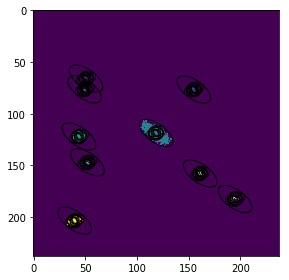

In [211]:
fig, ax1 = plt.subplots()

ax1.imshow(segm) # complete
for i in range(len(apertures)):
    apertures[i][0].plot()

fig.tight_layout()

With apertures now defined, we can *finally* measure the flux of each source. The [`aperture_photometry`](http://photutils.readthedocs.io/en/stable/api/photutils.aperture_photometry.html#photutils.aperture_photometry) function returns the flux (actually counts) in an image for the provided apertures. It takes the image, apertures, and bakground image as arguments.

*Note* - the background has already been subtracted from these images so we currently do not have an estimate of the **full** background for these sources.

We will create a background image that is approximately correct (we know this because we know the properties of the SDSS survey and detector). In this case what we are doing is not only incorrect, it's entirely made up and should not be repeated in your own work. Nevertheless, this (bad) approximation is necessary to produce uncertainty estimates.

Execute the cell below to create an uncertainty image to use with the `aperture_photometry` function.

In [213]:
bkg = np.random.normal(100, 35, r_data.shape)
uncertainty_img = calc_total_error(r_data, bkg - np.mean(bkg), 1)


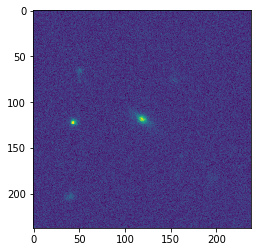

In [214]:
img_clean = r_data - bkg
plt.imshow(img_clean)

**Problem 4c**

Measure the counts and uncertainty detected from each source within the apertures defined in 4a. 

*Hint* - you will need to loop over each aperture as `aperture_photometry` does not take multiple apertures of different shapes as a single argument. 

In [231]:
source_cnts = np.zeros(len(apertures))
source_cnts_unc = np.zeros(len(apertures))
for source_num, ap in enumerate(apertures):
    phot = aperture_photometry(r_data, ap)
    source_cnts[source_num] = phot['aperture_sum'].sum()
    source_cnts_unc[source_num] = np.sqrt(phot['aperture_sum'].sum())
    
    

In [232]:
source_cnts

array([ 99479.9631326 ,  84193.64960098,  40471.23349483, 163035.59190685,
       111660.05189646,  40021.89088921,  60376.72224022,  75493.07267119,
       113185.79671311])

The images have been normalized to a zero point of 30. Thus, we can convert from counts to magnitudes via the following equation: 

$$m = 30 - 2.5 \log (\mathrm{counts}).$$

Recall from Dora's talk that the uncertainty of the magnitude measurements can be calculated as: 

$$\frac{2.5}{\ln(10)} \frac{\sigma_\mathrm{counts}}{\mathrm{counts}}.$$

**Problem 4d**

Calculate the magnitude of each source in the image.

In [238]:
source_mag = 30 - 2.5*np.log10(source_cnts) # complete
source_mag_unc = 2.5 * source_cnts_unc / (np.log(10)* source_cnts)



That's it! You've measured the magnitude for every source in the image.

As previously noted, the images provided for this dataset are centered are galaxies within a cluster, and ultimately, these galaxies are all that we care about. For this first image, that means we care about the galaxy centered at $(x,y) \approx (118, 118)$. 

**Problem 4e**

What is the magnitude of the galaxy we care about for this image? [We will need this moving forward]

In [243]:
source_mag[0]


17.50566096088037

## Problem 5) Multiwavelength Photometry

Ultimately we want to measure colors for these galaxies. We now know the $r$-band magnitude for galaxy 85698, we need to measure the $g$ and $i$ band magnitudes as well. 

**Problem 5a** Using the various pieces described above, write a function to measure the magnitude of the galaxy at the center of the image. You should create a new background image for every field. 

*Hint* - creating an actual function is essential as we will eventually run this on every image. 

*Hint 2* - `source_properties` directly measures source centroids, use this it will be faster.

In [241]:
def cluster_galaxy_photometry(data):
    '''
    Determine the magnitude of the galaxy at the center of the image
    
    Parameters
    ----------
    data : array-like
        Background subtracted 2D image centered on the galaxy
        of interest
    
    Returns
    -------
    mag : float
        Magnitude of the galaxy
    
    mag_unc : float
        Uncertainty of the magnitude measurement
    '''

    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    # complete
    
    
    return mag, mag_unc

**Problem 5b**

Confirm that the function calculates the same $r$-band mag that was calculated in **Problem 4**.

In [ ]:
# complete

print("""Previously, we found m = {:.3f} mag. 
This new function finds m = {:.3f} mag.""".format( # complete

**Problem 5c** 

Use this new function to calculate the galaxy magnitude in the $g$ and the $i$ band, and determine the $g - r$ and $r - i$ colors of the galaxy.

In [ ]:
g_data = fits.getdata( # complete
i_data = fits.getdata( # complete

# complete
# complete
# complete
print("""The g-r color = {:.3f} +/- {:.3f} mag.
The r-i color = {:.3f} +/- {:.3f} mag""".format(g_mag - r_mag, np.hypot(g_mag_unc, r_mag_unc), 
                                                r_mag - i_mag, np.hypot(r_mag_unc, i_mag_unc)))

But wait!

**Problem 5d**

Was this calculation "fair"?

*Hint* - this is a relatively red galaxy.

**Solution 5d**

This calculation was not "fair" because identical apertures were not used in all 3 filters. 

**Problem 5e** 

[Assuming your calculation was not fair] Calculate the $g - r$ and $r - i$ colors of the galaxy in a consistent fashion.

*Hint* - split your initial function into two functions, one to determine an aperture and another to measure photometry. Use the $r$-band image (where the signal-to-noise ratio of the data is highest) to define the aperture for all 3 images.

In [ ]:
def cluster_galaxy_aperture(data):
# complete
# complete
# complete
# complete
# complete
# complete
# complete
# complete
# complete
# complete
# complete
    return aperture

def cluster_galaxy_phot(data, aperture):
# complete
# complete
# complete
# complete
# complete
    return mag, mag_unc

In [ ]:
r_ap = # complete

# complete
# complete
# complete

print("""The g-r color = {:.3f} +/- {:.3f} mag.
The r-i color = {:.3f} +/- {:.3f} mag""".format(g_mag - r_mag, np.hypot(g_mag_unc, r_mag_unc), 
                                                r_mag - i_mag, np.hypot(r_mag_unc, i_mag_unc)))

## Challenge Problem) Colors as a Function of Radius

Each of the provided FITS images corresponds to a single galaxy in the galaxy cluster. Measure the colors for each galaxy, and plot these colors as a function of cluster radius.

*Hint* - the file `galsAngSep.txt` has the galaxy names and separation from the center of the cluster.

In [ ]:
g - i = mag_g - mag_i
r - g = mag_r - mag_g
g - r = mag_g - mag_r

sep = open('galsAngSep.txt')
plt.plot(sep, g - i)
plt.plot(sep, r - g)
plt.plot(sep, g - i)
